## Autonomous Driving part 1

### Importing required library

In [ ]:
import pandas as pd
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers

### Preparing the dataset for model training

In [ ]:
labels_df= pd.read_csv("/content/drive/MyDrive/capstone data/labels.csv", sep=',', header=None)
labels_df.columns=['image_id','class','x_min','y_min','x_max','y_max']

In [ ]:
labels_df['image_id']= labels_df['image_id'].apply(lambda x: f'{x:08d}')

In [ ]:
labels_df= labels_df.iloc[:5000]

In [ ]:
images_dir= "/content/drive/MyDrive/capstone data/Images/"
images= []

for index , row in labels_df.iterrows():
  img_path= os.path.join(images_dir, f"{row['image_id']}.jpg")
  img= cv2.imread(img_path)

  if img is not None:
    processed_images= (cv2.resize(img, (224,224)))
    processed_images = np.array(processed_images)
    print("Images resized successfully.")
    images.append(processed_images)

  else:
    print("Error loading image:",img_path)

images= np.array(images)

if len(images)==0:
  print("No images loaded. Please check the image paths.")
else:
    print(f"{len(images)} images loaded successfully.")

Streaming output truncated to the last 5000 lines.
Images resized successfully.
Images resized successfully.
Images resized successfully.
Images resized successfully.
Images resized successfully.
Images resized successfully.
Images resized successfully.
Images resized successfully.
Images resized successfully.
Images resized successfully.
Images resized successfully.
Images resized successfully.
Images resized successfully.
Images resized successfully.
Images resized successfully.
Images resized successfully.
Images resized successfully.
Images resized successfully.
Images resized successfully.
Images resized successfully.
Images resized successfully.
Images resized successfully.
Images resized successfully.
Images resized successfully.
Images resized successfully.
Images resized successfully.
Images resized successfully.
Images resized successfully.
Images resized successfully.
Images resized successfully.
Images resized successfully.
Images resized successfully.
Images resized succes

In [ ]:
processed_images.shape

(224, 224, 3)

In [ ]:
images.shape

(5000, 224, 224, 3)

In [ ]:
vehicle_types= labels_df['class'].value_counts()
print("Distribution of vehicle types:")
print(vehicle_types)

labels_df= labels_df.sort_values('image_id')

Distribution of vehicle types:
class
car                      3378
pickup_truck              566
motorized_vehicle         365
bus                       153
articulated_truck         138
work_van                  118
single_unit_truck          97
pedestrian                 94
bicycle                    40
non-motorized_vehicle      31
motorcycle                 20
Name: count, dtype: int64


In [ ]:
labels= labels_df['class'].to_numpy()
bounding_boxes= labels_df[['x_min', 'y_min', 'x_max', 'y_max']].to_numpy()

unique_labels= np.unique(labels)
label_to_index= {label: index for index, label in enumerate(unique_labels)}
index_to_label= {index: label for index,label in enumerate(unique_labels)}
labels= np.array([label_to_index[label] for label in labels])

In [ ]:
X_train, X_test, y_train, y_test, bbox_train, bbox_test= train_test_split(images, labels, bounding_boxes, test_size=0.2, random_state=42)

### Creating a CNN architecture for object detection

In [ ]:
def create_model(input_shape, num_classes):
  inputs= keras.Input(shape= input_shape)
  x= layers.Conv2D(32,(3,3),activation='relu')(inputs)
  x= layers.MaxPooling2D((2,2))(x)
  x= layers.Conv2D(64,(3,3),activation='relu')(x)
  x= layers.MaxPooling2D((2,2))(x)
  x= layers.Conv2D(64,(3,3), activation='relu')(x)
  x= layers.Flatten()(x)
  x= layers.Dense(64, activation='relu')(x)
  vehicle_class= layers.Dense(num_classes, activation= 'softmax', name= 'vehicle_class')(x)
  bounding_box= layers.Dense(4, name= 'bounding_box')(x)

  model= keras.Model(inputs=inputs, outputs=[vehicle_class, bounding_box])
  return model

input_shape= images[0].shape
num_classes= len(unique_labels)
model= create_model(input_shape, num_classes)


model.compile(optimizer='adam', loss= {'vehicle_class': 'sparse_categorical_crossentropy', 'bounding_box': 'mse'},
              metrics= {'vehicle_class': 'accuracy', 'bounding_box': 'mae'})

model.fit(X_train, {'vehicle_class': y_train, 'bounding_box': bbox_train}, epochs=20, batch_size= 200 , validation_data= (X_test, {'vehicle_class':y_test, 'bounding_box': bbox_test}))



Epoch 1/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 460s 23s/step - bounding_box_mae: 792.5100 - loss: 2648218.5000 - vehicle_class_accuracy: 0.1114 - val_bounding_box_mae: 137.9075 - val_loss: 29809.6836 - val_vehicle_class_accuracy: 0.0090
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 500s 23s/step - bounding_box_mae: 132.6914 - loss: 28640.3340 - vehicle_class_accuracy: 0.4071 - val_bounding_box_mae: 118.7384 - val_loss: 22934.7695 - val_vehicle_class_accuracy: 0.6310
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 505s 23s/step - bounding_box_mae: 113.0012 - loss: 22187.2090 - vehicle_class_accuracy: 0.4955 - val_bounding_box_mae: 101.2033 - val_loss: 18464.7402 - val_vehicle_class_accuracy: 0.5670
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 506s 23s/step - bounding_box_mae: 101.5678 - loss: 18339.7383 - vehicle_class_accuracy: 0.5512 - val_bounding_box_mae: 98.3017 - val_loss: 17571.8633 - val_vehicle_class_accuracy: 0.5230
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 491s 23s/step - bounding_box_mae: 99.0104 - loss: 17701.9

### Evaluating the model

In [ ]:
test_results= model.evaluate(X_test, {'vehicle_class': y_test, 'bounding_box': bbox_test}, verbose=2)
print('\nTest results:', test_results)

32/32 - 32s - 1s/step - bounding_box_mae: 104.8087 - loss: 19933.9629 - vehicle_class_accuracy: 0.5790

Test results: [19933.962890625, 104.80873107910156, 0.5789999961853027]


### Running inferences on the images

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


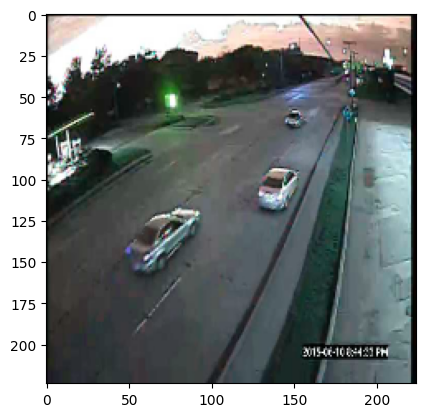

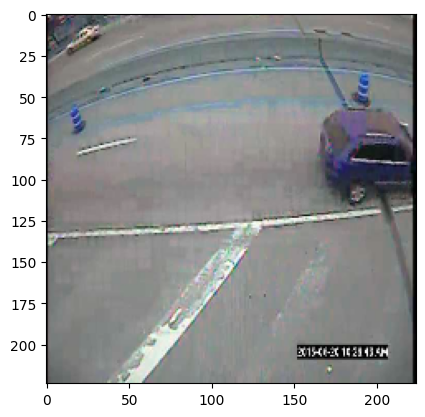

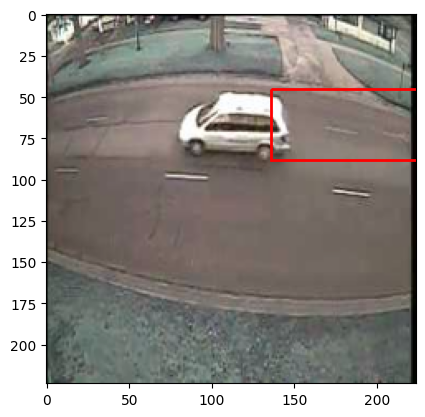

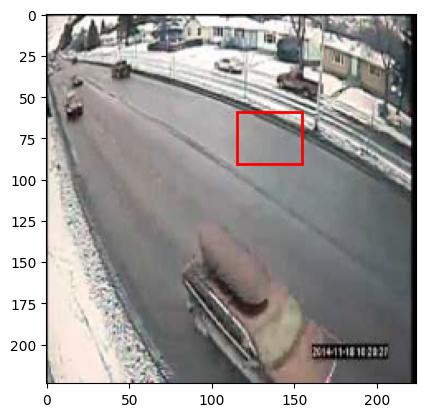

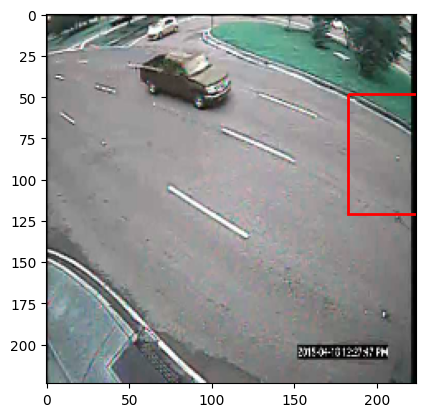

In [ ]:
import matplotlib.pyplot as plt

sample_images= X_test[:5]

predictions= model.predict(sample_images)

predicted_bounding_boxes= predictions[1]

for i in range(len(sample_images)):
  plt.figure()
  plt.imshow(sample_images[i])
  plt.gca().add_patch(plt.Rectangle((predicted_bounding_boxes[i][0], predicted_bounding_boxes[i][1]),
                                    predicted_bounding_boxes[i][2] - predicted_bounding_boxes[i][0],
                                    predicted_bounding_boxes[i][3] - predicted_bounding_boxes[i][1],
                                    fill= False, edgecolor= 'r', linewidth= 2
                                    ))
